In [ ]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt


In [ ]:
dataset=torchvision.datasets.CIFAR10(root='/data',train=True,transform=torchvision.transforms.ToTensor(),download=True)
test_data=torchvision.datasets.CIFAR10(root='/data',train=False,transform=torchvision.transforms.ToTensor(),download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 49380465.50it/s]


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [ ]:
print(len(dataset),len(test_data))
image,label=dataset[0]
image.shape

50000 10000


torch.Size([3, 32, 32])

In [ ]:
classes=dataset.classes
dataset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
#to plot image
def show_image(image,label):
  print('Label: ',classes[label])
  plt.imshow(image.permute(1,2,0)) #permute to move the no. of channels to last


Label:  truck


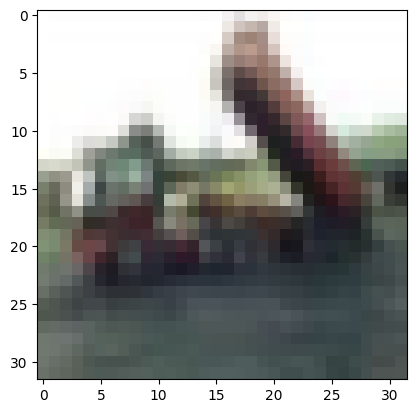

In [ ]:
image,label=dataset[0]
show_image(*dataset[2])

In [ ]:
#creating a validation set
from torch.utils.data import random_split
#to ensure we always create same validation set , we'll set a seed for the random number generator
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size
train_ds , val_ds = random_split(dataset,[train_size,val_size])
len(train_ds)

45000

In [ ]:
#making batches of the images
from torch.utils.data import DataLoader
batch_size = 128
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=batch_size*2)

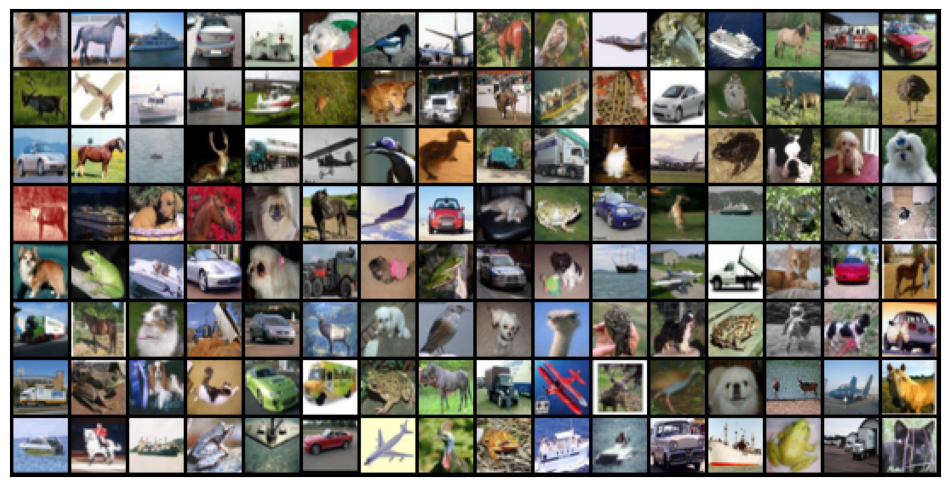

In [ ]:
#just looking at the batch of image
from torchvision.utils import make_grid
for images,label in train_dl:
  fig, axis = plt.subplots(figsize=(12,8))
  axis.set_xticks([])
  axis.set_yticks([])
  axis.imshow(make_grid(images, nrow=16).permute(1,2,0))
  break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ImageClassificationBase(nn.Module): #inheriting from the nn module
  def training_step(self,batch):
    images,labels = batch                 #from the batch seperating the inputs and outputs
    out = self(images)                    #generating the predictions
    loss=F.cross_entropy(out, labels)     #Calculate the loss
    return loss

  def validation_step(self,batch):
    images, labels = batch
    out = self(images)                       #generate the predictions
    loss = F.cross_entropy(out, labels)     #calculate the loss
    acc = accuracy(out, labels)             #calculate the accuracy
    return {'val_loss' : loss.detach(), "val_acc" : acc}

  def validation_epoch_end(self,results):
    batch_losses = [x['val_loss'] for x in results]
    epoch_loss = torch.stack(batch_losses).mean()    # stack-concatenate a sequence of tensors
    batch_accs = [x['val_acc'] for x in results]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

def accuracy(output, labels):
  _, preds = torch.max(output,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [ ]:
#Creating the class for the model
class Cifar10CNN(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential( #instead of normal self.fn things
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output= 64 X 16 X 16

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output= 128 X 8 X 8

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size= 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output= 256 X 4 X 4

        # nn.Conv2d(in_channels=256, out_channels=512, kernel_size= 3, stride=1, padding=1),
        # nn.ReLU(),
        # nn.Conv2d(512, 512, kernel_size= 3, stride=1, padding=1),
        # nn.ReLU(),
        # nn.MaxPool2d(2,2), #output= 512 X 2 X 2

        nn.Flatten(),
        nn.Linear(256*4*4,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )
  def forward(self,batch):
      return self.network(batch)
model=Cifar10CNN()

In [ ]:
for image,label in train_dl:
  print('image.shape: ',image.shape)
  out=model(image)
  print(out.shape)
  break


image.shape:  torch.Size([128, 3, 32, 32])
torch.Size([128, 10])


In [ ]:

@torch.no_grad()
def evaluate(model,val_dl):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_dl]  #cal the pred and acc for each batch
  return model.validation_epoch_end(outputs)                  #cal the avg loss and acc

def fit(epochs, lr,  model, train_dl, val_dl, opt_func):
    history=[]
    optimizer = opt_func(model.parameters(),lr)

    for epoch in range(epochs):
      #Training Stage
      model.train()
      train_losses=[]     #storing all the training losses to print
      for batch in train_dl:
        # print(1)
        loss=model.training_step(batch)
        train_losses.append(loss)
        # print(2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # print('running')

      #validation stage
      result = evaluate(model, val_dl)  #cal the loss and acc for each batch of val_dl
      result['train_loss']=torch.stack(train_losses).mean().item()
      model.epoch_end(epoch,result)
      history.append(result)
    return history


In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.3035614490509033, 'val_acc': 0.09858685731887817}

In [ ]:
lr=0.001
opt_func=torch.optim.Adam
epochs=10

history=fit(epochs,lr,model,train_dl,val_dl,opt_func)

Epoch [0], train_loss: 1.8269, val_loss: 1.4409, val_acc: 0.4567
Epoch [1], train_loss: 1.2844, val_loss: 1.1691, val_acc: 0.5786
Epoch [2], train_loss: 1.0320, val_loss: 1.0067, val_acc: 0.6395
Epoch [3], train_loss: 0.8745, val_loss: 0.9097, val_acc: 0.6735
Epoch [4], train_loss: 0.7647, val_loss: 0.7829, val_acc: 0.7209
Epoch [5], train_loss: 0.6617, val_loss: 0.7299, val_acc: 0.7441
Epoch [6], train_loss: 0.5800, val_loss: 0.7202, val_acc: 0.7538
Epoch [7], train_loss: 0.5001, val_loss: 0.7176, val_acc: 0.7620
Epoch [8], train_loss: 0.4288, val_loss: 0.7443, val_acc: 0.7634
Epoch [9], train_loss: 0.3642, val_loss: 0.7854, val_acc: 0.7639


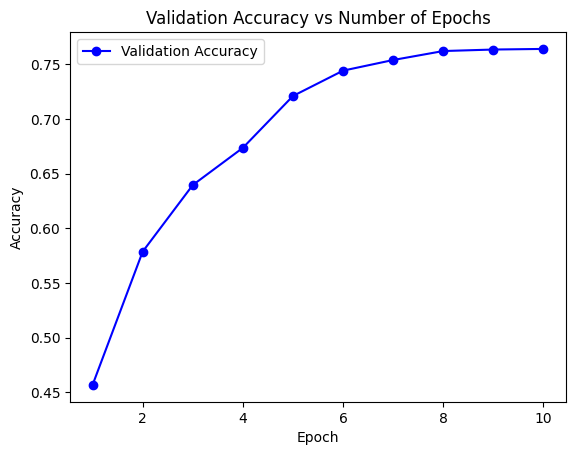

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    val_accuracies = [epoch_data['val_acc'] for epoch_data in history]
    epochs = range(1, len(val_accuracies) + 1)

    plt.plot(epochs, val_accuracies, 'bo-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title("Validation Accuracy vs Number of Epochs")
    plt.legend()
    plt.show()

# Call the function
plot_accuracies(history)


In [ ]:
def plot_accuracies(history):
  accuracies=[1,2,3]
  plt.plot(accuracies,'x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title("Accuracy vs no. of epochs")
  plt.show()

In [ ]:
torch.save(model.state_dict(),'cifar10_model.pth')

In [ ]:
print(type(history))
print(history)

<class 'list'>
[{'val_loss': 1.4409239292144775, 'val_acc': 0.4567325711250305, 'train_loss': 1.8269200325012207}, {'val_loss': 1.1691458225250244, 'val_acc': 0.5786075592041016, 'train_loss': 1.2843507528305054}, {'val_loss': 1.0066890716552734, 'val_acc': 0.6394761204719543, 'train_loss': 1.031967282295227}, {'val_loss': 0.909674346446991, 'val_acc': 0.6735064387321472, 'train_loss': 0.8744545578956604}, {'val_loss': 0.7828511595726013, 'val_acc': 0.720898449420929, 'train_loss': 0.7646856904029846}, {'val_loss': 0.7298874855041504, 'val_acc': 0.7440716624259949, 'train_loss': 0.6617358326911926}, {'val_loss': 0.7202027440071106, 'val_acc': 0.753791332244873, 'train_loss': 0.5799528360366821}, {'val_loss': 0.7175730466842651, 'val_acc': 0.761994481086731, 'train_loss': 0.5001348853111267}, {'val_loss': 0.7443300485610962, 'val_acc': 0.7633616328239441, 'train_loss': 0.42884957790374756}, {'val_loss': 0.7854440808296204, 'val_acc': 0.7639246582984924, 'train_loss': 0.3641969859600067}

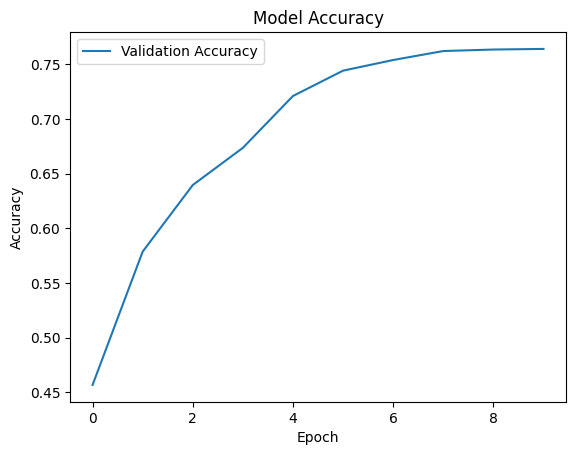

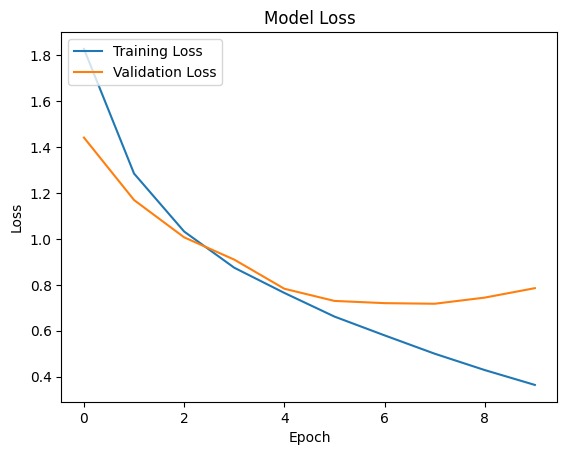

In [ ]:
import matplotlib.pyplot as plt

# Extract data from the list
val_loss = [epoch_data['val_loss'] for epoch_data in history]
val_acc = [epoch_data['val_acc'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]

# Plot Accuracy
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot Loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


100%|██████████| 170498071/170498071 [00:03<00:00, 55411520.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


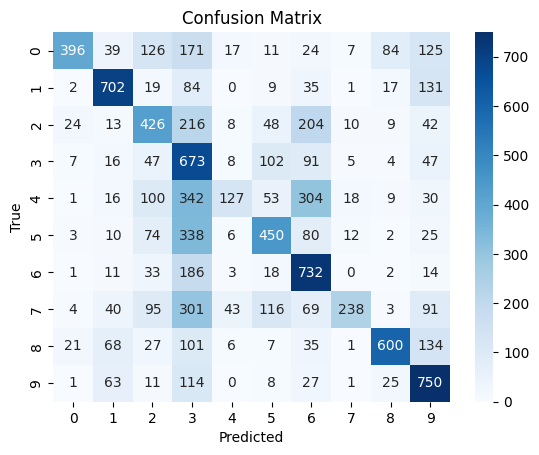

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations and DataLoader for the test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for CIFAR-10
])

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

# Ensure the model is in evaluation mode
model.eval()

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare to collect predictions and true labels
y_true = []
y_pred = []

# Perform inference
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass through the model
        outputs = model(inputs)

        # Get predicted class
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())  # Collect true labels
        y_pred.extend(predicted.cpu().numpy())  # Collect predicted labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# CIFAR-10 class names (modify if using a different dataset)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)


              precision    recall  f1-score   support

    airplane       0.86      0.40      0.54      1000
  automobile       0.72      0.70      0.71      1000
        bird       0.44      0.43      0.44      1000
         cat       0.27      0.67      0.38      1000
        deer       0.58      0.13      0.21      1000
         dog       0.55      0.45      0.49      1000
        frog       0.46      0.73      0.56      1000
       horse       0.81      0.24      0.37      1000
        ship       0.79      0.60      0.68      1000
       truck       0.54      0.75      0.63      1000

    accuracy                           0.51     10000
   macro avg       0.60      0.51      0.50     10000
weighted avg       0.60      0.51      0.50     10000

